#Data collection

In [2]:
import os
import time
import json
from PIL import Image
import urllib.request
from SPARQLWrapper import SPARQLWrapper, JSON
from urllib.error import HTTPError

endpoint_url = "https://query.wikidata.org/sparql"
img_data = {}

# Function to create a SPARQL query for a specific Wikidata entity (default: Q144/Dog)
# The query retrieves items, labels, and image URLs.
def query(wd='Q144', limit=5):
    return f"""SELECT ?item ?itemLabel ?pic
                WHERE {{
                  ?item wdt:P31 wd:{wd}.
                  ?item wdt:P18 ?pic.
                  SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
                }}
                LIMIT {limit}"""

# Function to execute the SPARQL query and return results in JSON format.
# Implements retry logic for handling '429 Too Many Requests' errors.
def get_results(endpoint_url, query):
    user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    for i in range(3):
        try:
            return sparql.query().convert()
        except HTTPError as e:
            if e.response.status_code == 429:
                retry_after = int(e.response.headers.get('Retry-After', '90'))
                print(f"Too Many Requests. Tentative dans {retry_after} secondes.")
                sleep(retry_after)
            else:
                raise e
    
    raise Exception("Nombre maximum de tentatives pour atteindre Wikidata atteint.")

# Function to create a directory for storing images if it doesn't already exist 
def createFolder(name='images'):
    if name not in os.listdir():
        os.mkdir(name)
    else:
        print('Dossier '+name+' déjà existant !')

# Function to check if a directory is empty - to avoid unnecessary re-downloading of images.
def isEmpty(name='images'):
    if len(os.listdir(name)) == 0:
        return True
    return False

# Function to add image data to the img_data dictionary for specified Wikidata entity.
# Downloads images and populates img_data with the relevant information.
def addImg(wd, limit):
    results = get_results(endpoint_url, query(wd, limit))
    for result in results['results']['bindings']:
        name_img = result['item']['value'].split("/")[-1] + "-" + wd # nom donné aux images téléchargées "numéro d'image - numéro de catégorie"        
        img_data[name_img] = {}
        downloadImage(result['pic']['value'], name_img)
        
# Function to add images for all specified Wikidata entities.
def addAllImg(wd, limit):
    for w in wd:
        addImg(w, limit)
        
# Function to download an image from a given URL and save it with a specified filename.
def downloadImage(url, name_img='img0'):
    full_path = 'images/' + name_img + '.jpg'
    urllib.request.urlretrieve(url, full_path)
    time.sleep(1)
    
# Function to initialize img_data with information about already downloaded images.    
def initAlreadyDownload(namefolder='images'):
    for image in os.listdir(namefolder):
        img_data[image.split(".")[0]] = {}

# Main function to download all images for specified Wikidata entities.
# Checks if images are already downloaded to avoid redundancy.
def downloadAllImages(wd=['Q144'], limit=5):
    createFolder()
    if not isEmpty():
        print('Images déjà téléchargées !')
        initAlreadyDownload()
        return False
    addAllImg(wd, limit)
    return True 

bdd = ['Q3305213'] #Chien, drapeau, ile, sandwich, peinture,
downloadAllImages(wd=bdd,limit=30)
print(img_data)

{'Q728373-Q3305213': {}, 'Q729194-Q3305213': {}, 'Q729197-Q3305213': {}, 'Q731639-Q3305213': {}, 'Q732011-Q3305213': {}, 'Q732277-Q3305213': {}, 'Q732821-Q3305213': {}, 'Q733017-Q3305213': {}, 'Q734082-Q3305213': {}, 'Q734197-Q3305213': {}, 'Q734834-Q3305213': {}, 'Q735061-Q3305213': {}, 'Q735326-Q3305213': {}, 'Q736446-Q3305213': {}, 'Q737062-Q3305213': {}, 'Q738038-Q3305213': {}, 'Q738242-Q3305213': {}, 'Q740212-Q3305213': {}, 'Q742801-Q3305213': {}, 'Q743491-Q3305213': {}, 'Q743643-Q3305213': {}, 'Q743787-Q3305213': {}, 'Q745098-Q3305213': {}, 'Q745415-Q3305213': {}, 'Q746716-Q3305213': {}, 'Q747304-Q3305213': {}, 'Q747914-Q3305213': {}, 'Q749201-Q3305213': {}, 'Q754135-Q3305213': {}}


In [3]:

import time
import shutil
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import webcolors

# Function to remove an image from the 'images' folder.
def removeImage(name):
    image_path = "images/" + name
    if os.path.isfile(image_path):
        os.remove(image_path)
        print(f"L'image {name} a été supprimée.")
    else:
        print(f"Impossible de trouver le fichier {image_path}")

# Function to retrieve and store metadata for a given image.
def getMetaImg(name, imgfile):
    # Exif keys for date and model
    DATE_KEY = 36867
    MODEL_KEY = 272
    
    # Updating image data with size, orientation, and format
    img_data[name].update({
        #'size': [getSizeImg(imgfile.size), imgfile.size],
        'size': getSizeImg(imgfile.size),
        'orientation': getOrientationImg(imgfile.size),
        'format': imgfile.format,
    })
    # Getting dominant colors of the image
    getColorsImg(name, imgfile)

    # Extracting EXIF data for additional metadata
    exif_data = imgfile._getexif()
    if exif_data is not None:
        if DATE_KEY in exif_data:
            img_data[name]['date'] = exif_data[DATE_KEY]
        if MODEL_KEY in exif_data:
            img_data[name]['model'] = exif_data[MODEL_KEY]

# Function to determine the orientation of an image.
def getOrientationImg(size): #(largeur,hauteur)
    width,height = size
    return "landscape" if width > height else "portrait" if height > width else "squared"

# Function to categorize image size.
def getSizeImg(size): #(largeur,hauteur)
    width,height = size
    return "large" if width*height>1920*1080 else "small" if width*height<640*480 else "medium"

# Function to identify dominant colors in an image using KMeans clustering.
def getColorsImg(name, imgfile, cluster_nbr=2, n_init=1):
    img_data[name]['colors'] = []
    
    # Resizing image for faster processing
    imgfile = imgfile.resize((int(imgfile.size[0]/2), int(imgfile.size[1]/2)))

    # Converting image to a numpy array
    img_array = np.array(imgfile)
    try:
        img_vector = img_array.reshape(-1, 3)
        clusters = MiniBatchKMeans(n_clusters=cluster_nbr, n_init=n_init, random_state=69).fit(img_vector) #Random state pour garder la meme seed ppour toutes les images
        
        # Storing the RGB values of cluster centers (dominant colors)
        for i, center in enumerate(clusters.cluster_centers_):
            rgb = tuple(map(int, center))
            img_data[name]['colors'].append(rgb)
            
    except Exception as e:
        print(f'Pas de couleur : {e}')
        
# Function to convert RGB values to the closest named color.
def RGBtoName(rgb):
    try:
        # Attempt to find the exact color name
        color_name = webcolors.rgb_to_name(rgb)
    except ValueError:
        # If exact name not found, find the closest color name
        min_difference = None
        closest_color = None
        for name, hex_value in webcolors.CSS3_NAMES_TO_HEX.items():
            r_c, g_c, b_c = webcolors.hex_to_rgb(hex_value)
            difference = sum([(r_c - rgb[0]) ** 2, (g_c - rgb[1]) ** 2, (b_c - rgb[2]) ** 2])
            if min_difference is None or difference < min_difference:
                min_difference = difference
                closest_color = name
        color_name = closest_color
    return color_name
    
# Function to open an image, extract metadata, and handle errors.
def openImgGetMeta(name):
    try:
        with Image.open("images/"+name) as imgfile:
            name = name.split(".")[0]
            getMetaImg(name, imgfile)
        imgfile.close()
        return True
    except FileNotFoundError as e:
        print('Impossible de trouver le fichier {}: {}'.format("images/"+name, e))
        return False
    except Exception as e:
        print('Erreur lors de l\'ouverture de l\'image {}: {}'.format("images/"+name, e))
        removeImage(name)
        return False


# Function to extract metadata from all images in a specified directory.
def openGetMetaAllImg(namefolder='images'):
    for image in os.listdir(namefolder):
        # Ignore .ipynb_checkpoints and non-image files
        if image.endswith((".png", ".jpg", ".jpeg", ".gif", ".bmp")):
            openImgGetMeta(image)

# Calling the function to process all images
openGetMetaAllImg()


Erreur lors de l'ouverture de l'image images/Q733017-Q3305213.jpg: Image size (226536844 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
L'image Q733017-Q3305213.jpg a été supprimée.


C:\Users\alex1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\Image.py:3182: DecompressionBombWarning: Image size (175214016 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [4]:
import requests
from random import randint, choice
import json

# Function to export data to a JSON file.
def exportToJSON(data,name='img_data.json'):
    with open(name, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    print("done")

# Function to open a JSON file and load its content or create a new file if it doesn't exist.
def openJSON(file="img_data.json"):
    if not os.path.exists(file):
        with open(file, 'w') as f:
            json.dump({}, f)
        with open(file, 'r') as f:
            data = json.load(f)
        return data
    
# Function to make an API request to Wikidata and retrieve image categories.
def wikidataAPI(_id,lang):
    url = f"https://www.wikidata.org/w/api.php?action=wbgetentities&ids={_id}&props=labels|claims&languages={lang}&format=json"
    response = requests.get(url)
    return json.loads(response.text)

# Function to find tags for an image from Wikidata.
def findTagsImg(_id, lang='en'): #"Q7704028-Q144"
    image_id, cat_id = _id.split("-")
    # Get image and category data from Wikidata
    img_data = wikidataAPI(image_id,lang)
    cat_data = wikidataAPI(cat_id,lang)
    # Extract main category label in the desired language
    main_tag = cat_data.get('entities', {}).get(cat_id, {}).get('labels', {}).get(lang, {}).get('value', '')
    # Extract and format category data from image data
    claims = img_data.get("entities", {}).get(image_id, {}).get("claims", {})
    categories = formatCategory([x['mainsnak']['datavalue']['value'] for prop in ["P910", "P373"] for x in claims.get(prop, [])])
    if main_tag not in categories:
        categories.append(main_tag)
    categories = [main_tag]    
    return categories
    
# Helper function to format category strings.
def formatCategory(categories):
    categories_ = []
    removeCar = ['(', ')']
    splitCar = [',', ' ']
    for category in categories:
        if isinstance(category, str):
            for car in removeCar:
                category = category.replace(car, '')
            for car in splitCar:
                parts = category.split(car)
                if len(parts) > 1:
                    categories_.extend(parts[1:])
                    category = parts[0]
            categories_.append(category.lower())
    return categories_
    
# Function to add tags to images in JSON data.
def addTagsJSON(image_id = "Q7704028", categories=[]):
    data = openJSON(file="img_data.json")
    data[image_id]['tags'] = categories

# Function to remove images from JSON file and directory if they lack color metadata.
def delete_image_without_color_metadata(json_file='img_data.json', image_folder='images'):
    with open(json_file, 'r') as f:
        json_data = json.load(f)
    images_to_delete = []
    for image in json_data:
        if not 'colors' in json_data[image] or not json_data[image].get("colors",False):
            images_to_delete.append(image)
    for image in images_to_delete:
        if os.path.isfile(os.path.join(image_folder, image)):
            os.remove(os.path.join(image_folder, image))
        del json_data[image]
    print(f"{len(images_to_delete)} images ont été supprimées")

    with open(json_file, 'w') as f:
        json.dump(json_data, f)
    return json_data

# Function to format and fill missing data for images.
def data_formatage(data):
    for image in data:
        if not data[image].get("size",False):
            data[image]["size"] = ""
        if not data[image].get("orientation",False):
            data[image]["orientation"] = ""
        if not data[image].get("format",False):
            data[image]["format"] = choice(["JPEG","PNG","JPG"])
        if not data[image].get("tags",False):
            data[image]["tags"] = ""
        data[image]["date"]=randint(1999,2024)
        if not data[image].get("model", False):
            data[image]["model"]=choice(["Canon","Nikon", "Sony","Fujifilm","Olympus","Panasonic","Pentax","iphone","samsung","lenovo"])         
    return data

# Function to add tags to all images in the JSON data.
def addAllTagsJSON():
    for _id in data:
        data[_id]['tags'] = findTagsImg(_id)
    return data

# Main workflow: Process data, add tags, format data, and export to JSON.
data = img_data
data = addAllTagsJSON()
data = data_formatage(data)
exportToJSON(data)

# Clean up the data by removing images without color metadata.
img_data = delete_image_without_color_metadata()

done
1 images ont été supprimées


In [5]:
class User:
    # Initialize a new User object with optional favorite pictures.
    def __init__(self, favorite_pictures=None):
        self._favorite_colors = []  # Store user's favorite colors
        self._favorite_orientations = []  # Store user's favorite orientations
        self._favorite_sizes = []  # Store user's favorite sizes
        self._favorite_tags = []  # Store user's favorite tags
        self._favorite_pictures = [] if favorite_pictures is None else favorite_pictures  # Store user's favorite pictures

    # String representation of a User object.
    def __str__(self):
        return f"User with favorite color {self._favorite_colors}, orientation {self._favorite_orientations}, size {self._favorite_sizes}, tags {self._favorite_tags} and favorite pictures {self._favorite_pictures}"

    # Add a picture to the user's favorites and update corresponding attributes.
    def add_favorite_picture(self, picture):
        self._favorite_pictures.append(picture)
        img_data = data[picture.split(".")[0]]  # Extract metadata from global 'data' dictionary
        self._favorite_colors.append(img_data["colors"])  # Update favorite colors
        self._favorite_orientations.append(img_data["orientation"])  # Update favorite orientations
        self._favorite_tags.append(img_data["tags"])  # Update favorite tags
        self._favorite_sizes.append(img_data["size"])  # Update favorite sizes

    # Remove a picture from the user's favorites and update corresponding attributes.
    def remove_favorite_picture(self, picture):
        picture_index = self._favorite_pictures.index(picture)
        self._favorite_pictures.pop(picture_index)  # Remove picture
        # Remove corresponding attributes
        self._favorite_colors.pop(picture_index)
        self._favorite_orientations.pop(picture_index)
        self._favorite_tags.pop(picture_index)
        self._favorite_sizes.pop(picture_index)

    # Getters to retrieve user's favorite pictures and their associated metadata.
    def get_favorite_pictures(self):
        return self._favorite_pictures

    def get_favorite_tags(self):
        return self._favorite_tags

    def get_favorite_orientations(self):
        return self._favorite_orientations

    def get_favorite_colors(self):
        return self._favorite_colors

    def get_favorite_sizes(self):
        return self._favorite_sizes


In [8]:
import random
# Create a list to store user objects
number_users = 15
users = [None] * number_users

# Loop to create each user with a random list of favorite pictures
for i in range(number_users):
    # Determine a random number of pictures a user likes, between 10 to 30
    number_pictures_liked = random.randint(10, 30)
    # Ensure the number of pictures liked does not exceed the total number of available pictures
    max_pictures_liked = min(len(dataFrame), 30)
    if max_pictures_liked == 0:
        print("Il n'y a pas d'images dans le répertoire.")
    else:
        number_pictures_liked = random.randint(1, max_pictures_liked)
        
    # Create a User object with a random selection of favorite pictures from the dataFrame
    user = User(favorite_pictures=random.sample(list(dataFrame.index), k=number_pictures_liked))
    users[i] = user
    # Print the list of favorite pictures for the created user
    print(user.get_favorite_pictures())


['Q747914-Q3305213', 'Q746716-Q3305213', 'Q749201-Q3305213', 'Q747304-Q3305213', 'Q731639-Q3305213', 'Q737062-Q3305213', 'Q745098-Q3305213', 'Q754135-Q3305213', 'Q729197-Q3305213', 'Q734834-Q3305213', 'Q738038-Q3305213', 'Q729194-Q3305213', 'Q732821-Q3305213', 'Q743491-Q3305213', 'Q734082-Q3305213', 'Q736446-Q3305213', 'Q732277-Q3305213', 'Q735326-Q3305213', 'Q743643-Q3305213', 'Q734197-Q3305213', 'Q738242-Q3305213', 'Q728373-Q3305213', 'Q740212-Q3305213', 'Q735061-Q3305213', 'Q745415-Q3305213', 'Q743787-Q3305213', 'Q742801-Q3305213', 'Q732011-Q3305213']
['Q732011-Q3305213']
['Q732277-Q3305213', 'Q728373-Q3305213', 'Q747914-Q3305213', 'Q742801-Q3305213']
['Q729197-Q3305213', 'Q745415-Q3305213', 'Q745098-Q3305213', 'Q747304-Q3305213', 'Q738242-Q3305213', 'Q734082-Q3305213', 'Q731639-Q3305213', 'Q743643-Q3305213', 'Q734834-Q3305213']
['Q738038-Q3305213', 'Q745098-Q3305213', 'Q736446-Q3305213', 'Q747914-Q3305213', 'Q754135-Q3305213', 'Q734197-Q3305213', 'Q742801-Q3305213', 'Q737062-Q33052

In [9]:
user = users[0]
print(user._favorite_pictures)

['Q747914-Q3305213', 'Q746716-Q3305213', 'Q749201-Q3305213', 'Q747304-Q3305213', 'Q731639-Q3305213', 'Q737062-Q3305213', 'Q745098-Q3305213', 'Q754135-Q3305213', 'Q729197-Q3305213', 'Q734834-Q3305213', 'Q738038-Q3305213', 'Q729194-Q3305213', 'Q732821-Q3305213', 'Q743491-Q3305213', 'Q734082-Q3305213', 'Q736446-Q3305213', 'Q732277-Q3305213', 'Q735326-Q3305213', 'Q743643-Q3305213', 'Q734197-Q3305213', 'Q738242-Q3305213', 'Q728373-Q3305213', 'Q740212-Q3305213', 'Q735061-Q3305213', 'Q745415-Q3305213', 'Q743787-Q3305213', 'Q742801-Q3305213', 'Q732011-Q3305213']


In [7]:
import pandas as pd 
dataFrame = pd.read_json('img_data.json').T
dataFrame

,size,orientation,format,colors,tags,date,model
Q728373-Q3305213,large,portrait,JPEG,"[[89, 72, 52], [176, 171, 167]]",[painting],2017,Sony
Q729194-Q3305213,large,portrait,JPEG,"[[50, 42, 27], [128, 104, 66]]",[painting],2002,Panasonic
Q729197-Q3305213,large,landscape,JPEG,"[[144, 133, 121], [81, 68, 55]]",[painting],2013,COOLPIX P5000
Q731639-Q3305213,large,portrait,JPEG,"[[181, 168, 155], [86, 73, 62]]",[painting],2013,Panasonic
Q732011-Q3305213,large,portrait,JPEG,"[[88, 72, 51], [161, 154, 134]]",[painting],2005,Fujifilm
Q732277-Q3305213,large,landscape,JPEG,"[[50, 42, 33], [178, 152, 117]]",[painting],2013,Panasonic
Q732821-Q3305213,large,landscape,JPEG,"[[33, 36, 51], [153, 145, 124]]",[painting],2003,Fujifilm
Q734082-Q3305213,large,landscape,JPEG,"[[91, 108, 96], [165, 168, 163]]",[painting],2004,Fujifilm
Q734197-Q3305213,medium,portrait,JPEG,"[[95, 82, 83], [184, 175, 151]]",[painting],2023,Panasonic
Q734834-Q3305213,large,landscape,JPEG,"[[221, 212, 195], [86, 69, 46]]",[painting],2020,Sony


In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

# Load data from a JSON file and transpose it for better structure.
dataFrame = pd.read_json('img_data.json').T

# Convert 'size' from categorical to numerical values.
dataFrame['size'] = dataFrame['size'].map({'small': 0, 'medium': 0.5, 'large':1})

# Convert 'orientation' from categorical to numerical values.
dataFrame['orientation'] = dataFrame['orientation'].map({'landscape': 0, 'portrait': 1, 'squared':0.5})

# Convert 'format' from categorical to numerical values.
dataFrame['format'] = dataFrame['format'].map({'JPEG': 0, 'MPO': 0.5, 'PNG':1})

# Ensure 'colors' column contains lists; if not, fill with a default value.
dataFrame['colors'] = dataFrame['colors'].apply(lambda x: [[0,0,0], [0,0,0]] if isinstance(x, float) else x)

# Extract and normalize RGB values from the first and second colors.
dataFrame["r1"] = [couleur[0][0]/255 if len(couleur) > 0 and len(couleur[0]) > 0 else 0 for couleur in dataFrame["colors"]]
dataFrame["g1"] = [couleur[0][1]/255 if len(couleur) > 0 and len(couleur[0]) > 1 else 0 for couleur in dataFrame["colors"]]
dataFrame["b1"] = [couleur[0][2]/255 if len(couleur) > 0 and len(couleur[0]) > 2 else 0 for couleur in dataFrame["colors"]]
dataFrame["r2"] = [couleur[1][0]/255 if len(couleur) > 1 and len(couleur[1]) > 0 else 0 for couleur in dataFrame["colors"]]
dataFrame["g2"] = [couleur[1][1]/255 if len(couleur) > 1 and len(couleur[1]) > 1 else 0 for couleur in dataFrame["colors"]]
dataFrame["b2"] = [couleur[1][2]/255 if len(couleur) > 1 and len(couleur[1]) > 2 else 0 for couleur in dataFrame["colors"]]

# Convert RGB values to hexadecimal color codes.
dataFrame["hex1"] = dataFrame.apply(lambda row: '#{:02x}{:02x}{:02x}'.format(int(row["r1"]*255), int(row["g1"]*255), int(row["b1"]*255)), axis=1)
dataFrame["hex2"] = dataFrame.apply(lambda row: '#{:02x}{:02x}{:02x}'.format(int(row["r2"]*255), int(row["g2"]*255), int(row["b2"]*255)), axis=1)

# Remove unnecessary columns (original 'colors' and metadata columns).
dataFrame = dataFrame.drop(columns=['colors'])
dataFrame = dataFrame.drop(columns=['date','model'])

# Binarize the tags using MultiLabelBinarizer for further analysis.
mlb = MultiLabelBinarizer()
tags_binarized = mlb.fit_transform(dataFrame['tags'])
tags_df = pd.DataFrame(tags_binarized, columns=mlb.classes_, index=dataFrame.index)
dataFrame = pd.concat([dataFrame, tags_df], axis=1)
dataFrame.drop('tags', axis=1, inplace=True)

# Add a 'liked' column initialized with zeros.
dataFrame['liked'] = np.zeros(len(dataFrame['r1'].index))
# Update the 'liked' column based on the user's favorite pictures.
for img in user._favorite_pictures:
    dataFrame.at[img.split('.')[0], 'liked'] = 1
dataFrame

,size,orientation,format,r1,g1,b1,r2,g2,b2,hex1,hex2,painting,liked
Q728373-Q3305213,1.0,1.0,0.0,0.349020,0.282353,0.203922,0.690196,0.670588,0.654902,#594834,#b0aba7,1,1.0
Q729194-Q3305213,1.0,1.0,0.0,0.196078,0.164706,0.105882,0.501961,0.407843,0.258824,#322a1b,#806842,1,1.0
Q729197-Q3305213,1.0,0.0,0.0,0.564706,0.521569,0.474510,0.317647,0.266667,0.215686,#908579,#514437,1,1.0
Q731639-Q3305213,1.0,1.0,0.0,0.709804,0.658824,0.607843,0.337255,0.286275,0.243137,#b5a89b,#56493e,1,1.0
Q732011-Q3305213,1.0,1.0,0.0,0.345098,0.282353,0.200000,0.631373,0.603922,0.525490,#584833,#a19a86,1,1.0
Q732277-Q3305213,1.0,0.0,0.0,0.196078,0.164706,0.129412,0.698039,0.596078,0.458824,#322a21,#b29875,1,1.0
Q732821-Q3305213,1.0,0.0,0.0,0.129412,0.141176,0.200000,0.600000,0.568627,0.486275,#212433,#99917c,1,1.0
Q734082-Q3305213,1.0,0.0,0.0,0.356863,0.423529,0.376471,0.647059,0.658824,0.639216,#5b6c60,#a5a8a3,1,1.0
Q734197-Q3305213,0.5,1.0,0.0,0.372549,0.321569,0.325490,0.721569,0.686275,0.592157,#5f5253,#b8af97,1,1.0
Q734834-Q3305213,1.0,0.0,0.0,0.866667,0.831373,0.764706,0.337255,0.270588,0.180392,#ddd4c3,#56452e,1,1.0


In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random

# Assuming dataFrame is defined and contains your image data
total_images = len(dataFrame)
min_likes = int(0.05 * total_images)  # 5% of total
max_likes = int(0.20 * total_images)  # 20% of total
number_of_likes = random.randint(min_likes, max_likes)  # Random number between 5% and 20%

# Initialize resultframe with all images as 'not liked'
resultframe = pd.DataFrame(np.full(total_images, "not liked"), columns=['liked'], index=dataFrame.index)

# Randomly select images to like
liked_indices = random.sample(list(dataFrame.index), number_of_likes)
for index in liked_indices:
    resultframe.at[index, 'liked'] = 'liked'

# Encode the 'liked' labels
le7 = LabelEncoder()
resultframe['liked'] = le7.fit_transform(resultframe['liked'])

print(f"Number of images liked: {number_of_likes}")
print(resultframe)


Number of images liked: 5
                  liked
Q728373-Q3305213      1
Q729194-Q3305213      1
Q729197-Q3305213      1
Q731639-Q3305213      1
Q732011-Q3305213      1
Q732277-Q3305213      0
Q732821-Q3305213      1
Q734082-Q3305213      1
Q734197-Q3305213      1
Q734834-Q3305213      1
Q735061-Q3305213      1
Q735326-Q3305213      0
Q736446-Q3305213      0
Q737062-Q3305213      1
Q738038-Q3305213      1
Q738242-Q3305213      1
Q740212-Q3305213      0
Q742801-Q3305213      1
Q743491-Q3305213      1
Q743643-Q3305213      0
Q743787-Q3305213      1
Q745098-Q3305213      1
Q745415-Q3305213      1
Q746716-Q3305213      1
Q747304-Q3305213      1
Q747914-Q3305213      1
Q749201-Q3305213      1
Q754135-Q3305213      1


In [13]:
# Necessary library imports for data processing and machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import tree
import graphviz
import pydotplus
import pandas as pd
import io

# Identifying columns in the dataframe that contain string values
string_cols = dataFrame.select_dtypes(include=['object']).columns

# Converting these string columns to a numeric type, handling non-numeric values as errors
for col in string_cols:
    dataFrame[col] = pd.to_numeric(dataFrame[col], errors='coerce')
 
# Display the shape of the dataframe after preprocessing
print(dataFrame.shape)
print(resultframe.shape)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataFrame, resultframe, test_size=0.3, random_state=69)

# Normalizing the data to ensure feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Training the decision tree classifier model
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

# Evaluating the model's performance
y_pred = dtc.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=1))

# Visualizing the decision tree
dot_data = tree.export_graphviz(
    dtc,
    out_file=None,
    filled=True,
    rounded=True,
    class_names=le7.inverse_transform(resultframe.liked.unique()),
    feature_names=dataFrame.columns,
    proportion=True,
    impurity=False,
    precision=2,
    node_ids=True
)
# Creating and displaying the graph
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
# Converting the graph to an image and displaying it
img = Image.open(io.BytesIO(pydot_graph.create_png()))
display(img)

# Displaying the importance of each feature in the decision tree
importances = dtc.feature_importances_
indices = np.argsort(importances)[::-1]
print("Importance des variables :")
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, dataFrame.columns[indices[f]], importances[indices[f]]))

# Affichage des prédictions
print(y_pred)


(28, 13)
(28, 1)
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.83      0.71      0.77         7

    accuracy                           0.67         9
   macro avg       0.58      0.61      0.58         9
weighted avg       0.72      0.67      0.69         9



C:\Users\alex1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\alex1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\alex1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


InvocationException: GraphViz's executables not found

In [15]:
import numpy as np
# Entraînement du modèle
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=69)
X_train = scaler.fit_transform(X_train)
rfc.fit(X_train, y_train.ravel())


# Évaluation du modèle
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=1))

# Affichage de l'importance des variables
importances = rfc.feature_importances_  # Assurez-vous que 'rfc' est le modèle correct
indices = np.argsort(importances)[::-1]
print("Importance des variables :")
for f in range(X_train.shape[1]):  # S'assure que X_train est un tableau NumPy
    print("%d. feature %s (%f)" % (f + 1, dataFrame.columns[indices[f]], importances[indices[f]]))
    
print(y_pred)

NameError: name 'RandomForestClassifier' is not defined

AttributeError: 'DataFrame' object has no attribute 'ravel'

#Data Visualization 

{2014: 7, 2005: 3, 2021: 6, 2023: 6, 2012: 4, 2008: 3, 2013: 3, 2024: 7, 2001: 6, 2007: 5, 2016: 3, 2003: 2, 2000: 3, 2009: 6, 2018: 3, 2015: 6, 2022: 10, 2019: 1, 1999: 6, 2006: 3, 2004: 3, 2002: 2, 2020: 3, 2017: 1, 2011: 2}


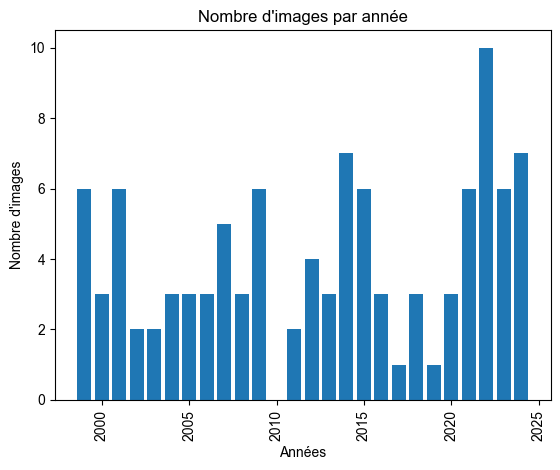

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
nb_images_year = {}

with open('img_data.json', 'r') as f:
    data = json.load(f)
    for image in data:
        date = data[image]["date"] #Recupere la date de l'image
        nb_images_year[date] = nb_images_year.get(date,0) +1
    
print(nb_images_year)
noms = list(nb_images_year.keys())
valeurs = list(nb_images_year.values())

plt.bar(noms, valeurs)
plt.title("Nombre d'images par année")
plt.xlabel("Années")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=90)
plt.show()

{'small': 21, 'large': 53, 'medium': 30}
{'portrait': 25, 'squared': 2, 'landscape': 77}
{'Pentax': 7, 'Canon': 6, 'iphone': 2, 'Nikon': 10, 'lenovo': 4, 'samsung': 10, 'GT-I9100': 1, 'Sony': 9, 'Fujifilm': 9, 'DMC-TZ27': 1, 'Canon EOS 650D': 1, 'Panasonic': 6, 'COOLPIX S5100\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00': 1, 'Canon EOS REBEL T1i': 1, 'NIKON D610': 1, 'PENTAX Optio330RS': 1, 'E5200': 1, 'XZ-1            ': 1, 'Canon DIGITAL IXUS v3': 1, 'Canon EOS 5D Mark II': 1, 'NIKON D7000': 1, 'NIKON D5000': 1, 'DSC-V1': 1, 'Canon EOS 450D': 1, 'Canon EOS 400D DIGITAL': 1, 'Canon DIGITAL IXUS 430': 1, 'Hasselblad CF528-39 - Hasselblad H Series': 1, 'Olympus': 6, 'FinePix S100FS ': 1, 'Hasselblad H4D-50': 1, 'MP260 series': 1, 'P65+': 1, 'HP Scanjet G3010': 1, 'iPhone 4S': 1, 'iPhone XS': 1, 'DMC-FZ20': 1, 'NIKON D90': 1, 'C765UZ': 1, 'Canon PowerShot SD20': 1, 'DSC-H50': 1, 'iPhone 8 Plus': 1, 'DSC-T100': 1, 'DSC-P150': 1, 'E5700': 1, 'Canon DIGITAL IXUS 1

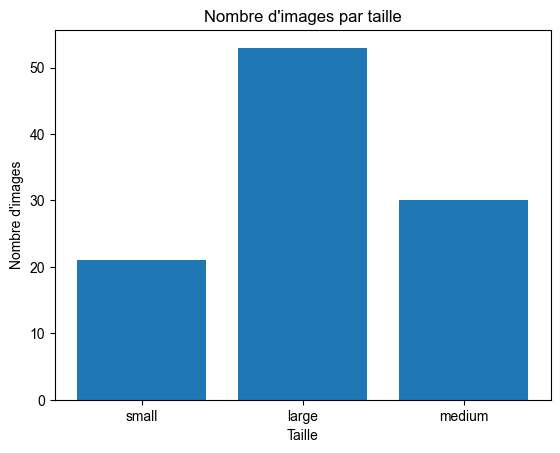

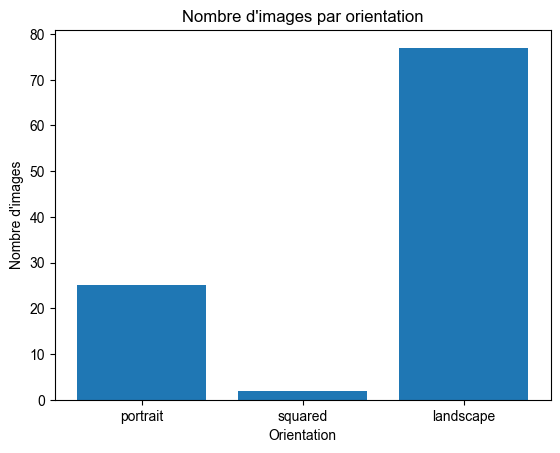

C:\Users\chaha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 0 ( ) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


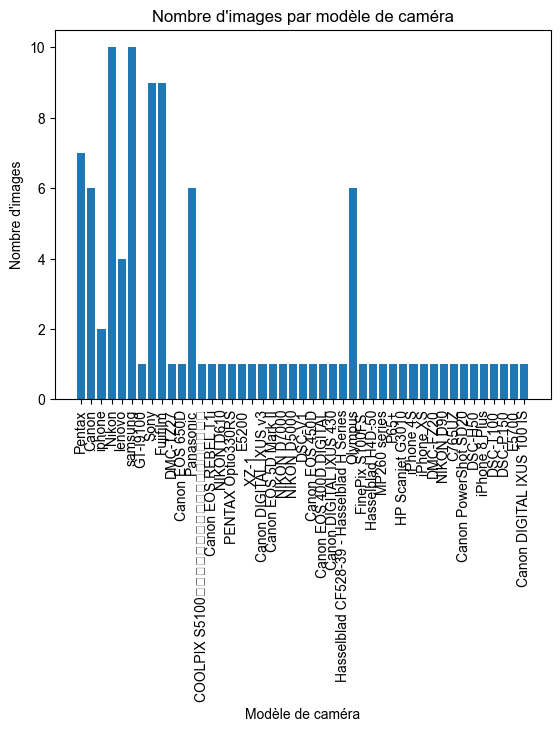

In [12]:

# Initialize dictionaries to count the number of images by size, orientation, and camera model
nb_images_size = {}
nb_images_orientation = {}
nb_images_camera = {}
# Set default font style for plots
plt.rcParams['font.family'] = 'Arial'

# Open and read data from the JSON file
with open('img_data.json', 'r') as f:
    data = json.load(f)
    # Iterate through each image in the dataset
    for image in data :
       # Get and count the size of each image
       size = data[image].get('size','')
       nb_images_size[size] = nb_images_size.get(size,0) +1
       
        # Get and count the orientation of each image
       orientation = data[image].get('orientation','')
       nb_images_orientation[orientation] = nb_images_orientation.get(orientation,0) +1
        
        # Get and count the camera model of each image
       camera = data[image].get('model','')
       nb_images_camera[camera] = nb_images_camera.get(camera,0) +1

# Print out the counts for each category
print(nb_images_size)
print(nb_images_orientation)
print(nb_images_camera)

# Plotting the number of images by size
entity1 = list(nb_images_size.keys())
val1 = list(nb_images_size.values())
plt.bar(entity1, val1)
plt.title("Nombre d'images par taille")
plt.xlabel("Taille")
plt.ylabel("Nombre d'images")
plt.show()

# Plotting the number of images by orientation
entity2 = list(nb_images_orientation.keys())
val2 = list(nb_images_orientation.values())
plt.bar(entity2, val2)
plt.title("Nombre d'images par orientation")
plt.xlabel("Orientation")
plt.ylabel("Nombre d'images")
plt.show()

# Plotting the number of images by camera model
entity3 = list(nb_images_camera.keys())
val3 = list(nb_images_camera.values())
plt.bar(entity3, val3)
plt.title("Nombre d'images par modèle de caméra")
plt.xlabel("Modèle de caméra")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=90) # Fait pivoter les étiquettes x de 45 degrés pour améliorer la lisibilité
plt.show()

{'Pentax': ['Pentax'], 'Canon': ['Canon', 'Canon EOS 650D', 'Canon EOS REBEL T1i', 'Canon DIGITAL IXUS v3', 'Canon EOS 5D Mark II', 'Canon EOS 450D', 'Canon EOS 400D DIGITAL', 'Canon DIGITAL IXUS 430', 'Canon PowerShot SD20', 'Canon DIGITAL IXUS 100 IS'], 'iphone': ['iphone'], 'Nikon': ['Nikon'], 'lenovo': ['lenovo'], 'samsung': ['samsung'], 'GT-I9100': ['GT-I9100'], 'Sony': ['Sony'], 'Fujifilm': ['Fujifilm'], 'DMC-TZ27': ['DMC-TZ27'], 'Panasonic': ['Panasonic'], 'COOLPIX': ['COOLPIX S5100\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'], 'NIKON': ['NIKON D610', 'NIKON D7000', 'NIKON D5000', 'NIKON D90'], 'PENTAX': ['PENTAX Optio330RS'], 'E5200': ['E5200'], 'XZ-1': ['XZ-1            '], 'DSC-V1': ['DSC-V1'], 'Hasselblad': ['Hasselblad CF528-39 - Hasselblad H Series', 'Hasselblad H4D-50'], 'Olympus': ['Olympus'], 'FinePix': ['FinePix S100FS '], 'MP260': ['MP260 series'], 'P65+': ['P65+'], 'HP': ['HP Scanjet G3010'], 'iPhone': ['iPhone 4S', 'iPhone XS', 'iPhone 8

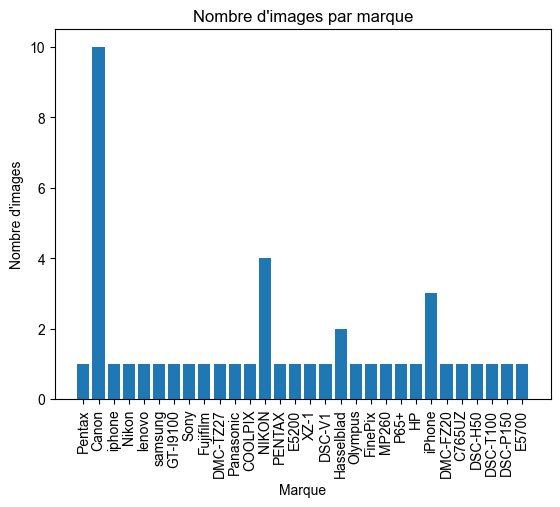

In [13]:
marques = {}

for modele in nb_images_camera:
    marque = modele.split(' ')[0].encode('utf-8', 'ignore').decode('utf-8') # Encode la chaîne de caractères en utilisant l'encodage UTF-8 et en ignorant les caractères invalides
    if marque in marques:
        marques[marque].append(modele)
    else:
        marques[marque] = [modele]

print(marques)

entity4 = list(marques.keys())
print([len(el) for el in marques.values()])
val4 = [len(el) for el in marques.values()]
plt.bar(entity4, val4)
plt.title("Nombre d'images par marque")
plt.xlabel("Marque")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=90) # Fait pivoter les étiquettes x de 45 degrés pour améliorer la lisibilité
plt.show()


# Color Characteristics
## En 2D 

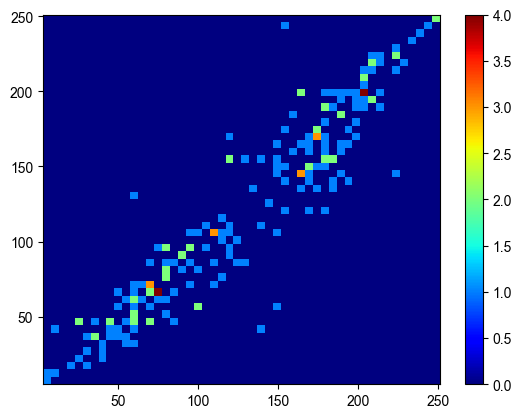

In [14]:
# Initialiser un tableau vide pour stocker toutes les couleurs
all_colors = []

# Parcourir toutes les images et ajouter leurs couleurs à la liste de toutes les couleurs

for image in data:
    if 'colors' in data[image]:
        colors = data[image]['colors']
        all_colors += colors

# Convertir la liste de couleurs en un tableau NumPy
all_colors = np.array(all_colors)

# Créer l'histogramme en utilisant Matplotlib
plt.hist2d(all_colors[:, 0], all_colors[:, 1], bins=50, cmap=plt.cm.jet)
plt.colorbar()

# Afficher l'histogramme
plt.show()

## En 3D mais avec toutes les couleurs de chaques images

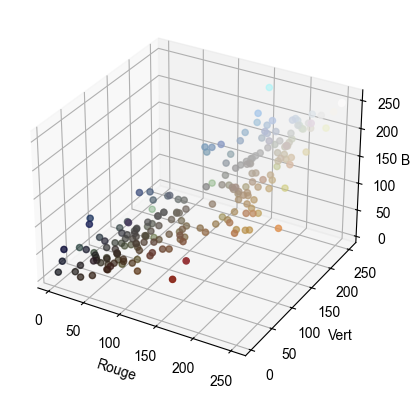

In [15]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcl

# Initialiser les listes de coordonnées x, y et z
x = []
y = []
z = []

# Initialiser la liste de couleurs
colors = []

# Parcourir toutes les images dans le fichier JSON
for image in data:
    # Vérifier si l'image actuelle a une clé 'colors'
    if 'colors' in data[image]:
        # Parcourir toutes les couleurs pour cette image
        for color in data[image]['colors']:
            # Ajouter les valeurs RGB aux listes x, y et z
            r, g, b = color
            x.append(r)
            y.append(g)
            z.append(b)
            # Ajouter la couleur à la liste de couleurs
            colors.append(mcl.to_hex([r/255,g/255,b/255]))

# Créer une figure en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Ajouter les points au graphique en 3D
ax.scatter(x, y, z, c=colors, marker='o')

# Ajouter des labels aux axes
ax.set_xlabel('Rouge')
ax.set_ylabel('Vert')
ax.set_zlabel('Bleu')

# Afficher le graphique
plt.show()


# Recommendation System

## 1- Sur une image

In [16]:
# Prédiction sur une image au hasard:
dataFrame = pd.read_json('img_data.json').T

ligne_aleatoire = dataFrame.sample()

ligne_aleatoire

,size,orientation,format,colors,tags,date,model
Q231953-Q3305213,large,landscape,JPEG,"[[77, 66, 45], [213, 197, 173]]",[painting],2021,iphone


## 2- Sur toutes nos données

Accuracy: 0.5769230769230769
Predictions pour l'ensemble de nos images : Q1060353-Q144 : 0
Predictions pour l'ensemble de nos images : Q109353074-Q28803 : 1
Predictions pour l'ensemble de nos images : Q111589124-Q28803 : 0
Predictions pour l'ensemble de nos images : Q113945861-Q28803 : 1
Predictions pour l'ensemble de nos images : Q1171851-Q144 : 0
Predictions pour l'ensemble de nos images : Q12065066-Q144 : 0
Predictions pour l'ensemble de nos images : Q124351850-Q28803 : 1
Predictions pour l'ensemble de nos images : Q1320354-Q144 : 0
Predictions pour l'ensemble de nos images : Q1360835-Q144 : 1
Predictions pour l'ensemble de nos images : Q13647435-Q144 : 1
Predictions pour l'ensemble de nos images : Q1393864-Q144 : 0
Predictions pour l'ensemble de nos images : Q1408045-Q28803 : 0
Predictions pour l'ensemble de nos images : Q1502051-Q144 : 1
Predictions pour l'ensemble de nos images : Q1554131-Q144 : 0
Predictions pour l'ensemble de nos images : Q155695-Q144 : 1
Predictions pour l'ens

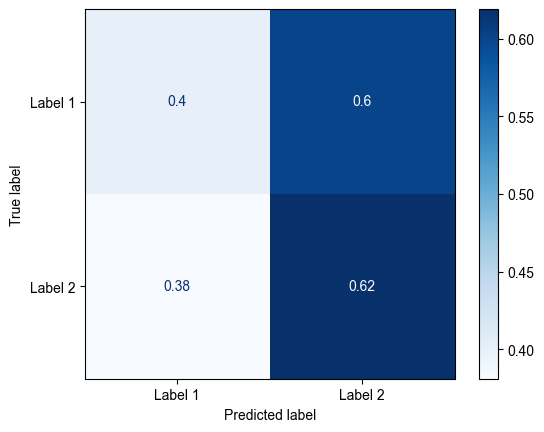

In [42]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Sample data
data = []
with open('img_data.json') as f:
    json_data = json.load(f)
    for image in json_data:
        try:
            data.append([
                str(json_data[image]["colors"][0]),
                str(json_data[image]["colors"][1]),
                json_data[image]["size"],
                json_data[image]["orientation"],
                json_data[image]["format"]
            ])
        except:
            pass

# Encode categorical features and labelss
label_encoders = [LabelEncoder() for _ in range(len(data[0]))]
encoded_data = []
for i, column in enumerate(zip(*data)):
    encoded_data.append(label_encoders[i].fit_transform(column))

X = list(zip(*encoded_data))  # Features
y = np.ravel(resultframe)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train the logistic regression classifier
classifier = svm.SVC(class_weight={1: 1, 0: 6})
classifier.fit(X_train, y_train)

# Predictions
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Sample prediction
for image in json_data:
    sample_item = [
        str(json_data[image]["colors"][0]),
        str(json_data[image]["colors"][1]),
        json_data[image]["size"],
        json_data[image]["orientation"],
        json_data[image]["format"]
    ]
    encoded_item = [label_encoders[i].transform([val])[0] for i, val in enumerate(sample_item)]
    prediction = classifier.predict([encoded_item])[0]
    print(f"Predictions pour l'ensemble de nos images : {image} : {prediction}")

cm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Label 1", "Label 2"])
disp.plot(cmap=plt.cm.Blues)

# Tests avec Unittest

In [47]:
import unittest
import json
from datetime import datetime

# Test suite for verifying various attributes of images
class TestImageAttributes(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        with open('img_data.json') as file:
            cls.img_data = json.load(file)

    def test_images_downloaded(self):
         # Test to ensure each image has at least one expected category tag
        expected_categories = {'dog', 'flag', 'island', 'sandwich', 'painting'}
        for image_id, attributes in self.img_data.items():
            tags = set(attributes.get('tags', []))
            # Vérifie si au moins une des catégories attendues se trouve dans les tags de l'image
            self.assertTrue(any(tag in tags for tag in expected_categories), f"Échec pour {image_id}: aucune catégorie correspondante trouvée parmi {tags}")


    def test_colors(self):
         # Test to ensure color values are in the correct format
        for image_id, attributes in self.img_data.items():
            colors = attributes.get('colors', [])
            for color in colors:
                self.assertEqual(len(color), 3, f"Échec pour {image_id}: couleur non conforme {color}")
                for value in color:
                    self.assertTrue(0 <= value <= 255, f"Échec pour {image_id}: valeur de couleur invalide {value}")

    def test_orientation_size_model(self):
        # Test to check if orientation, size, and model are valid
        for image_id, attributes in self.img_data.items():
            orientation = attributes.get('orientation')
            size = attributes.get('size')
            model = attributes.get('model')
            self.assertIn(orientation, ['portrait', 'landscape', 'squared'], f"Échec pour {image_id}: orientation invalide {orientation}")
            self.assertIn(size, ['small', 'medium', 'large'], f"Échec pour {image_id}: taille invalide {size}")
            self.assertIsInstance(model, str, f"Échec pour {image_id}: modèle invalide {model}")

    def test_valid_sizes(self):
        # Test to check if image sizes are within a set of valid sizes
        valid_sizes = {'small', 'medium', 'large'}
        for image_id, attributes in self.img_data.items():
            size = attributes.get('size')
            self.assertIn(size, valid_sizes, f"Échec pour {image_id}: taille invalide {size}")

    def test_valid_orientations(self):
        # Test to check if image orientations are within a set of valid orientations
        valid_orientations = {'portrait', 'landscape', 'squared'}
        for image_id, attributes in self.img_data.items():
            orientation = attributes.get('orientation')
            self.assertIn(orientation, valid_orientations, f"Échec pour {image_id}: orientation invalide {orientation}")

    def test_valid_formats(self):
        # Test to check if image formats are within a set of valid formats
        valid_formats = {'JPEG', 'PNG', 'TIFF', 'MPO'}
        for image_id, attributes in self.img_data.items():
            format = attributes.get('format')
            self.assertIn(format, valid_formats, f"Échec pour {image_id}: format invalide {format}")

    def test_valid_dates(self):
        # Test to ensure the date is within an acceptable range
        for image_id, attributes in self.img_data.items():
            date = attributes.get('date')
            self.assertIsInstance(date, int, f"Échec pour {image_id}: date invalide {date}")
            self.assertTrue(1990 <= date <= 2024, f"Échec pour {image_id}: date hors plage {date}")

    def test_valid_models(self):
        # Test to check if camera models are valid strings
        for image_id, attributes in self.img_data.items():
            model = attributes.get('model')
            self.assertIsInstance(model, str, f"Échec pour {image_id}: modèle invalide {model}")

    def test_valid_and_temporally_consistent_dates(self):
        # Test to ensure the dates are valid and consistent with expected technology timelines
        earliest_acceptable_year = 1990  # Ajustez selon le contexte technologique pertinent
        current_year = datetime.now().year
        for image_id, attributes in self.img_data.items():
            date = attributes.get('date')
            self.assertIsInstance(date, int, f"Échec pour {image_id}: date invalide {date}")
            self.assertTrue(earliest_acceptable_year <= date <= current_year, 
                            f"Échec pour {image_id}: date hors plage {date} (attendu entre {earliest_acceptable_year} et {current_year})")


# Loading the test cases
test_loader = unittest.TestLoader()
test_suite = test_loader.loadTestsFromTestCase(TestImageAttributes)

# Running the tests
test_runner = unittest.TextTestRunner(verbosity=2)
test_runner.run(test_suite)

test_colors (__main__.TestImageAttributes) ... ok
test_images_downloaded (__main__.TestImageAttributes) ... ok
test_orientation_size_model (__main__.TestImageAttributes) ... ok
test_valid_and_temporally_consistent_dates (__main__.TestImageAttributes) ... ok
test_valid_dates (__main__.TestImageAttributes) ... ok
test_valid_formats (__main__.TestImageAttributes) ... ok
test_valid_models (__main__.TestImageAttributes) ... ok
test_valid_orientations (__main__.TestImageAttributes) ... ok
test_valid_sizes (__main__.TestImageAttributes) ... ok

----------------------------------------------------------------------
Ran 9 tests in 0.017s

OK


<unittest.runner.TextTestResult run=9 errors=0 failures=0>